In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('/home/antonius/Projects/DS_Projects/Check-ups/3_Machine_learning/data//churn-modeling.zip')

In [3]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


# Обучающая, валидационная и тестовая выборка

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
train, test = train_test_split(df,train_size=0.6,
                               random_state=42,
                               stratify=df['Exited'])

In [8]:
val, test = train_test_split(test,
                             train_size=0.5,
                             random_state=42,
                             stratify=test['Exited'])

In [7]:
train['age_group'] = pd.cut(train['Age'],[0,31,35,40,46,float('inf')])

In [9]:
model = train.groupby(['NumOfProducts','age_group'])['Exited'].mean().reset_index()

In [10]:
model = model.rename({'Exited':'score_prod_age'},axis=1)

In [11]:
train = train.merge(model,how='left',on=['NumOfProducts','age_group'])

In [12]:
test['age_group'] = pd.cut(test['Age'],[0,31,35,40,46,float('inf')])

In [13]:
test = test.merge(model,how='left',on=['NumOfProducts','age_group'])

In [14]:
test.head(2)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,age_group,score_prod_age
0,1510,15638149,Rowley,528,France,Male,37,6,103772.45,1,1,0,197111.99,0,"(35.0, 40.0]",0.209337
1,4868,15768124,Liu,648,France,Female,34,3,0.00,1,1,0,54726.43,0,"(31.0, 35.0]",0.140449


In [15]:
from catboost import CatBoostClassifier

In [16]:
X = ['CustomerId', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary']

cat_features = ['Geography','Gender']

y = ['Exited']

In [17]:
from catboost import Pool

train_data = Pool(data=train[X],
                  label=train[y],
                  cat_features=cat_features
                 )

valid_data = Pool(data=val[X],
                  label=val[y],
                  cat_features=cat_features
                 )

In [18]:
params = {'verbose':100,
          'random_seed':42,
          'learning_rate':0.01}

In [19]:
model = CatBoostClassifier(**params)

In [20]:
model.fit(train_data,eval_set=valid_data)

0:	learn: 0.6848575	test: 0.6849436	best: 0.6849436 (0)	total: 62.8ms	remaining: 1m 2s
100:	learn: 0.3908412	test: 0.3960174	best: 0.3960174 (100)	total: 570ms	remaining: 5.07s
200:	learn: 0.3457312	test: 0.3550825	best: 0.3550825 (200)	total: 1s	remaining: 3.98s
300:	learn: 0.3288071	test: 0.3427737	best: 0.3427737 (300)	total: 1.48s	remaining: 3.43s
400:	learn: 0.3192987	test: 0.3376845	best: 0.3376763 (399)	total: 1.9s	remaining: 2.83s
500:	learn: 0.3120470	test: 0.3355660	best: 0.3355660 (500)	total: 2.36s	remaining: 2.35s
600:	learn: 0.3054735	test: 0.3340160	best: 0.3340160 (600)	total: 2.79s	remaining: 1.85s
700:	learn: 0.2997053	test: 0.3329229	best: 0.3329229 (700)	total: 3.2s	remaining: 1.37s
800:	learn: 0.2946934	test: 0.3329302	best: 0.3326509 (735)	total: 3.62s	remaining: 899ms
900:	learn: 0.2890177	test: 0.3323449	best: 0.3323449 (900)	total: 4.05s	remaining: 445ms
999:	learn: 0.2831978	test: 0.3322903	best: 0.3321800 (964)	total: 4.47s	remaining: 0us

bestTest = 0.332180

In [21]:
test['score_catboost'] = model.predict_proba(test[X])[:,1]

# Скор и пороги

In [22]:
test.head(2)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,age_group,score_prod_age,score_catboost
0,1510,15638149,Rowley,528,France,Male,37,6,103772.45,1,1,0,197111.99,0,"(35.0, 40.0]",0.209337,0.119504
1,4868,15768124,Liu,648,France,Female,34,3,0.00,1,1,0,54726.43,0,"(31.0, 35.0]",0.140449,0.236840


In [23]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

<AxesSubplot: >

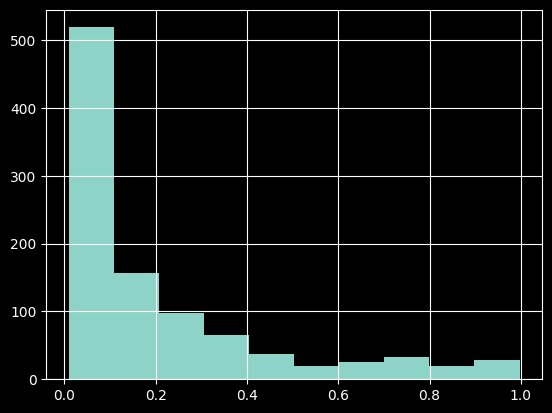

In [24]:
test['score_catboost'].hist()

In [25]:
train['Exited'].mean()

0.20366666666666666

In [26]:
test['y_pred'] = (test['score_catboost'] > 0.5) * 1

In [27]:
test.head(2)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,age_group,score_prod_age,score_catboost,y_pred
0,1510,15638149,Rowley,528,France,Male,37,6,103772.45,1,1,0,197111.99,0,"(35.0, 40.0]",0.209337,0.119504,0
1,4868,15768124,Liu,648,France,Female,34,3,0.00,1,1,0,54726.43,0,"(31.0, 35.0]",0.140449,0.236840,0


In [28]:
test['y_pred'].mean()

0.125

# Матрица ошибок

In [30]:
from sklearn.metrics import confusion_matrix

In [31]:
confusion_matrix(test['Exited'],test['y_pred'])

array([[769,  28],
       [106,  97]])

In [32]:
confusion_matrix(test['Exited'],test['y_pred'])

array([[769,  28],
       [106,  97]])

In [33]:
tn, fp, fn, tp = confusion_matrix(test['Exited'],test['y_pred']).ravel()

In [34]:
tn, fp, fn, tp

(769, 28, 106, 97)

# Recall (полнота)

In [35]:
recall = tp / (tp + fn)

In [36]:
recall

0.47783251231527096

In [37]:
from sklearn.metrics import recall_score

In [38]:
recall_score(test['Exited'],test['y_pred'])

0.47783251231527096

In [39]:
test['y_pred_1'] = 1

In [40]:
recall_score(test['Exited'],test['y_pred_1'])

1.0

# Precision (точность)

In [41]:
precision = tp / (tp + fp)

In [42]:
precision

0.776

In [43]:
from sklearn.metrics import precision_score

In [44]:
precision_score(test['Exited'],test['y_pred'])

0.776

In [45]:
precision_score(test['Exited'],test['y_pred_1'])

0.203

In [46]:
test['Exited'].mean()

0.203

# F1

In [47]:
f1 = (2 * recall * precision) / (recall + precision)

In [48]:
f1

0.5914634146341463

In [49]:
from sklearn.metrics import f1_score

In [50]:
f1_score(test['Exited'],test['y_pred'])

0.5914634146341463

# Accuracy

In [51]:
(test['Exited'] == test['y_pred']).mean()

0.866

In [52]:
(tp + tn) / (tp + tn + fp + fn)

0.866

In [53]:
from sklearn.metrics import accuracy_score

In [54]:
accuracy_score(test['Exited'],test['y_pred'])

0.866

In [55]:
test['Exited'].mean()

0.203

In [56]:
test['y_pred_0'] = 0

In [57]:
accuracy_score(test['Exited'],test['y_pred_0'])

0.797

In [58]:
1 - test['Exited'].mean()

0.7969999999999999

# Classification report

In [59]:
from sklearn.metrics import classification_report

In [60]:
print(classification_report(test['Exited'],test['y_pred']))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       797
           1       0.78      0.48      0.59       203

    accuracy                           0.87      1000
   macro avg       0.83      0.72      0.76      1000
weighted avg       0.86      0.87      0.85      1000



In [61]:
precision

0.776

In [62]:
recall

0.47783251231527096

In [63]:
f1

0.5914634146341463

# Предикт с другим порогом

In [64]:
test['y_pred_new'] = (test['score_catboost'] > 0.4) * 1

In [65]:
f1_score(test['Exited'],test['y_pred'])

0.5914634146341463

In [66]:
f1_score(test['Exited'],test['y_pred_new'])

0.6304347826086957

In [67]:
test

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,IsActiveMember,EstimatedSalary,Exited,age_group,score_prod_age,score_catboost,y_pred,y_pred_1,y_pred_0,y_pred_new
0,1510,15638149,Rowley,528,France,Male,37,6,103772.45,1,...,0,197111.99,0,"(35.0, 40.0]",0.209337,0.119504,0,1,0,0
1,4868,15768124,Liu,648,France,Female,34,3,0.00,1,...,0,54726.43,0,"(31.0, 35.0]",0.140449,0.236840,0,1,0,0
2,5360,15801832,Lombardo,684,Germany,Male,42,1,117691.00,1,...,1,23135.65,1,"(40.0, 46.0]",0.370441,0.483659,0,1,0,1
3,7777,15685243,Jamieson,736,France,Female,63,10,0.00,2,...,1,502.70,0,"(46.0, inf]",0.236364,0.061533,0,1,0,0
4,4231,15566660,Cole,670,France,Female,41,10,0.00,3,...,0,81602.02,0,"(40.0, 46.0]",0.895833,0.813196,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,745,15670755,Shaw,650,France,Male,60,8,0.00,2,...,1,102925.76,0,"(46.0, inf]",0.236364,0.050089,0,1,0,0
996,5620,15648951,Kao,785,Spain,Male,41,7,0.00,2,...,1,199108.88,0,"(40.0, 46.0]",0.108647,0.023766,0,1,0,0
997,8478,15685947,Henderson,556,Germany,Male,42,0,115915.53,2,...,1,125435.47,1,"(40.0, 46.0]",0.108647,0.184892,0,1,0,0
998,8674,15707637,Zikoranachukwudimma,765,France,Female,56,1,0.00,1,...,0,13228.93,1,"(46.0, inf]",0.527607,0.900887,1,1,0,1


In [68]:
len(test['score_catboost'])

1000

In [69]:
test['score_catboost'].nunique()

1000

In [70]:
thrs = [0] + list(test['score_catboost'].unique())

In [71]:
from tqdm.notebook import tqdm

In [72]:
result = []
for thr in tqdm(thrs):
  test['y_pred_new'] = (test['score_catboost'] > thr) * 1
  result.append((thr,
                 f1_score(test['Exited'],test['y_pred_new'])))

  0%|          | 0/1001 [00:00<?, ?it/s]

In [73]:
result[:10]

[(0, 0.33748960931005817),
 (0.1195041169886762, 0.5393939393939394),
 (0.2368402591997456, 0.6113360323886641),
 (0.4836587955414092, 0.6089552238805971),
 (0.06153334665794554, 0.44368600682593856),
 (0.8131962091361549, 0.3467741935483871),
 (0.12017845344336656, 0.5402124430955995),
 (0.12908649154582214, 0.5496894409937888),
 (0.08450569966077999, 0.4825806451612903),
 (0.020193774083758935, 0.35594713656387666)]

In [74]:
t = pd.DataFrame(result,columns=['thr','f1'])

In [75]:
t.sort_values('f1',ascending=False)

,thr,f1
101,0.345073,0.646465
977,0.348413,0.646310
87,0.357780,0.646154
169,0.331833,0.645320
605,0.335707,0.645161
...,...,...
427,0.992274,0.038647
797,0.992898,0.029126
936,0.992912,0.019512
527,0.993323,0.009804


In [76]:
t[t['f1'] == t['f1'].max()]

,thr,f1
101,0.345073,0.646465


In [77]:
test

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,IsActiveMember,EstimatedSalary,Exited,age_group,score_prod_age,score_catboost,y_pred,y_pred_1,y_pred_0,y_pred_new
0,1510,15638149,Rowley,528,France,Male,37,6,103772.45,1,...,0,197111.99,0,"(35.0, 40.0]",0.209337,0.119504,0,1,0,0
1,4868,15768124,Liu,648,France,Female,34,3,0.00,1,...,0,54726.43,0,"(31.0, 35.0]",0.140449,0.236840,0,1,0,0
2,5360,15801832,Lombardo,684,Germany,Male,42,1,117691.00,1,...,1,23135.65,1,"(40.0, 46.0]",0.370441,0.483659,0,1,0,1
3,7777,15685243,Jamieson,736,France,Female,63,10,0.00,2,...,1,502.70,0,"(46.0, inf]",0.236364,0.061533,0,1,0,0
4,4231,15566660,Cole,670,France,Female,41,10,0.00,3,...,0,81602.02,0,"(40.0, 46.0]",0.895833,0.813196,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,745,15670755,Shaw,650,France,Male,60,8,0.00,2,...,1,102925.76,0,"(46.0, inf]",0.236364,0.050089,0,1,0,0
996,5620,15648951,Kao,785,Spain,Male,41,7,0.00,2,...,1,199108.88,0,"(40.0, 46.0]",0.108647,0.023766,0,1,0,0
997,8478,15685947,Henderson,556,Germany,Male,42,0,115915.53,2,...,1,125435.47,1,"(40.0, 46.0]",0.108647,0.184892,0,1,0,0
998,8674,15707637,Zikoranachukwudimma,765,France,Female,56,1,0.00,1,...,0,13228.93,1,"(46.0, inf]",0.527607,0.900887,1,1,0,1


In [78]:
thrs = [0] + list(test['score_prod_age'].unique())

In [79]:
len(thrs)

17

In [80]:
result = []
for thr in tqdm(thrs):
  test['y_pred_new'] = (test['score_prod_age'] > thr) * 1
  result.append((thr,
                 f1_score(test['Exited'],test['y_pred_new'])))

  0%|          | 0/17 [00:00<?, ?it/s]

In [81]:
result[:10]

[(0, 0.33748960931005817),
 (0.20933734939759036, 0.5392354124748491),
 (0.1404494382022472, 0.5132450331125827),
 (0.3704414587332054, 0.5391304347826087),
 (0.23636363636363636, 0.5668934240362812),
 (0.8958333333333334, 0.13698630136986303),
 (0.11076443057722309, 0.47931526390870177),
 (0.5276073619631901, 0.22978723404255322),
 (0.033288948069241014, 0.3964143426294821),
 (0.028037383177570093, 0.35989256938227393)]

In [82]:
t = pd.DataFrame(result,columns=['thr','f1'])

In [83]:
t[t['f1'] == t['f1'].max()]

,thr,f1
4,0.236364,0.566893


# ROC

In [84]:
from sklearn.metrics import roc_curve

In [85]:
fprs, tprs, thrs = roc_curve(test['Exited'],test['score_catboost'])

In [86]:
roc = pd.DataFrame({'fpr':fprs,'tpr':tprs,'thr':thrs})

In [87]:
roc

,fpr,tpr,thr
0,0.000000,0.000000,1.997237
1,0.000000,0.004926,0.997237
2,0.000000,0.083744,0.931489
3,0.001255,0.083744,0.931480
4,0.001255,0.197044,0.836864
...,...,...,...
205,0.810540,0.990148,0.033532
206,0.810540,0.995074,0.033249
207,0.998745,0.995074,0.009967
208,0.998745,1.000000,0.009905


<AxesSubplot: xlabel='fpr'>

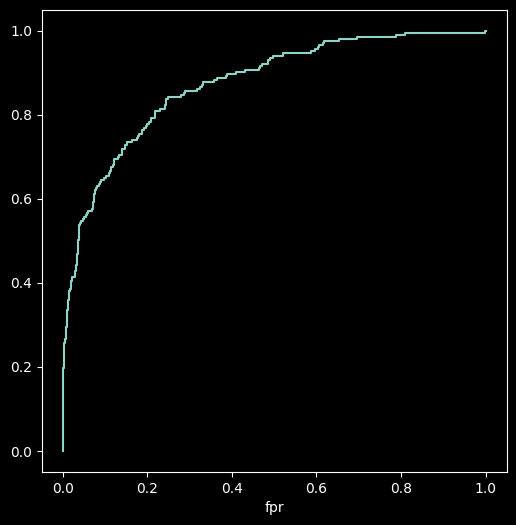

In [88]:
roc.set_index('fpr')['tpr'].plot(figsize=(6,6))

In [89]:
roc['random'] = roc['fpr']

In [90]:
roc['ideal'] = 1

<AxesSubplot: xlabel='fpr'>

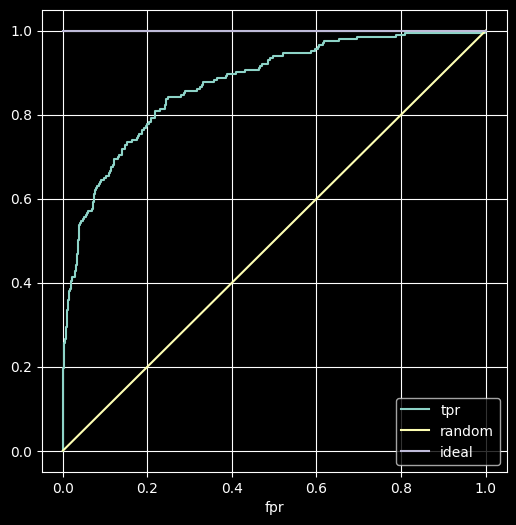

In [91]:
roc.plot(x='fpr',y=['tpr','random','ideal'],figsize=(6,6),grid=True)

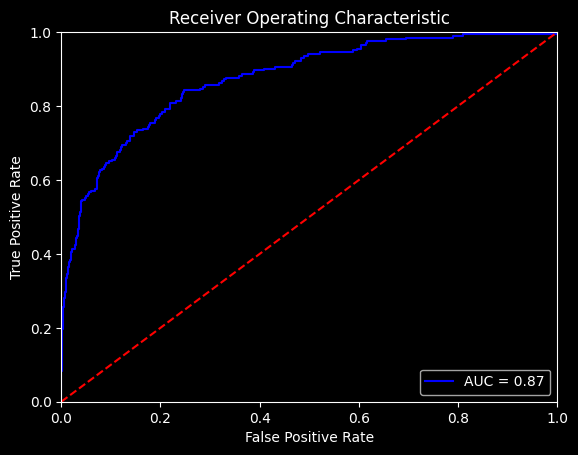

In [92]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(test['Exited'], test['score_catboost'])
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [93]:
from catboost.utils import get_roc_curve

In [94]:
test_data = Pool(data=test[X],
                  label=test[y],
                  cat_features=cat_features
                 )

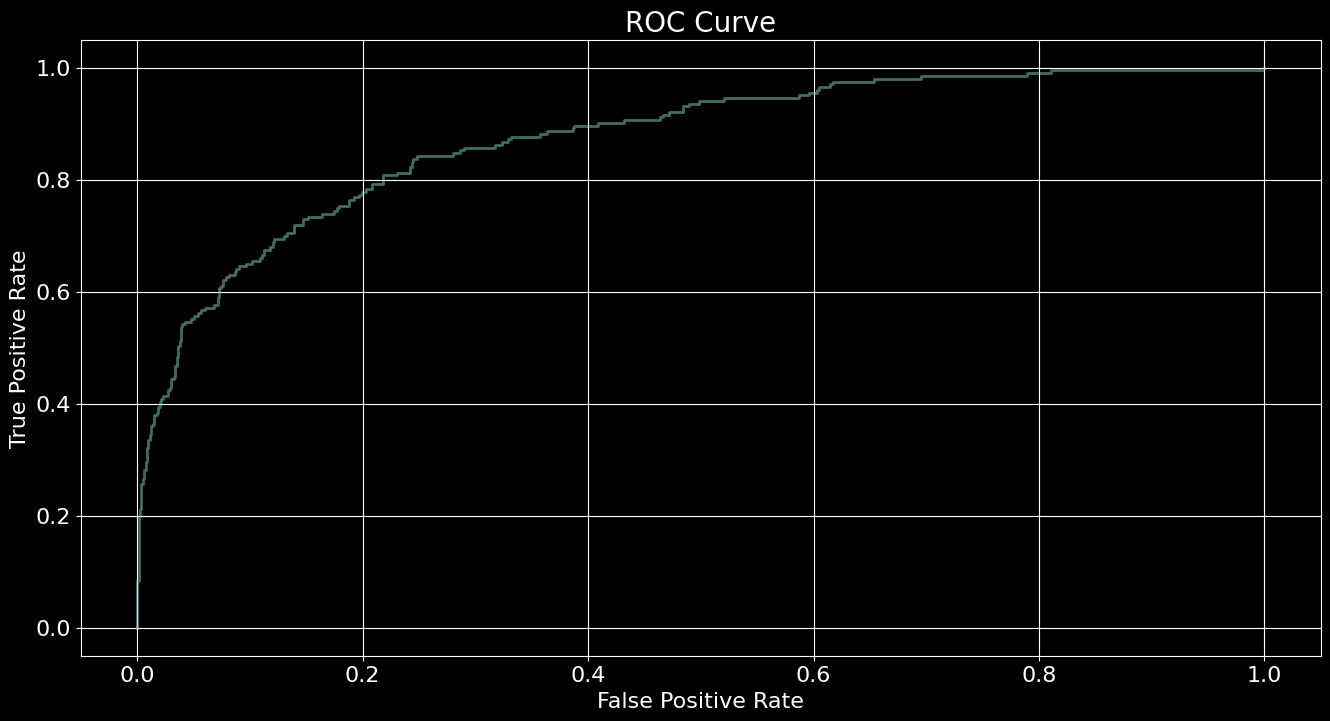

In [95]:
get_roc_curve(model,test_data,plot=True);

# AUC

In [96]:
from sklearn.metrics import roc_auc_score

In [97]:
roc_auc_score(test['Exited'],test['score_catboost'])

0.8736641716782763

In [98]:
params = {'verbose':100,
          'eval_metric':'AUC',
          'random_seed':42,
          'learning_rate':0.01}

In [99]:
model = CatBoostClassifier(**params)

In [100]:
model.fit(train_data,eval_set=valid_data)

0:	test: 0.8068744	best: 0.8068744 (0)	total: 11.1ms	remaining: 11.1s
100:	test: 0.8532306	best: 0.8532306 (93)	total: 655ms	remaining: 5.83s
200:	test: 0.8625665	best: 0.8625665 (200)	total: 1.2s	remaining: 4.78s
300:	test: 0.8663908	best: 0.8663908 (300)	total: 1.76s	remaining: 4.09s
400:	test: 0.8682075	best: 0.8683737 (384)	total: 2.35s	remaining: 3.52s
500:	test: 0.8682998	best: 0.8684784 (413)	total: 2.99s	remaining: 2.98s
600:	test: 0.8684969	best: 0.8686632 (542)	total: 3.54s	remaining: 2.35s
700:	test: 0.8688849	best: 0.8690265 (676)	total: 4.19s	remaining: 1.79s
800:	test: 0.8679119	best: 0.8690265 (676)	total: 4.86s	remaining: 1.21s
900:	test: 0.8677949	best: 0.8690265 (676)	total: 5.46s	remaining: 600ms
999:	test: 0.8670374	best: 0.8690265 (676)	total: 6.1s	remaining: 0us

bestTest = 0.8690265051
bestIteration = 676

Shrink model to first 677 iterations.


# ROC AUC при сильно несбалансированных классах

In [101]:
t = pd.DataFrame({'y_true':[0]*990 + [1]*10})

In [102]:
t['y_true'].mean()

0.01

In [103]:
import numpy as np

In [104]:
np.random.uniform(0,0.2)

0.10257156857103092

In [105]:
np.random.uniform(0.8,1)

0.966623177693717

In [106]:
np.concatenate([np.random.uniform(0,0.2,size=2),np.random.uniform(0.8,1,size=3)])

array([0.19584076, 0.18184837, 0.98979349, 0.84793569, 0.87955027])

In [107]:
t = pd.DataFrame({'y_true':[0]*990 + [1]*10})

In [108]:
np.random.seed(42)
t['y_score1'] = np.concatenate([np.random.uniform(0,0.2,size=970), # TN
                                np.random.uniform(0.8,1,size=20), # FP
                                np.random.uniform(0,0.2,size=5), # FN
                                np.random.uniform(0.8,1,size=5)]) # TP

In [109]:
roc_auc_score(t['y_true'],t['y_score1'])

0.7664646464646465

In [110]:
np.random.seed(42)
t['y_score2'] = np.concatenate([np.random.uniform(0,0.2,size=850), # TN
                                np.random.uniform(0.8,1,size=140), # FP
                                np.random.uniform(0,0.2,size=2), # FN
                                np.random.uniform(0.8,1,size=8)]) # TP

In [111]:
roc_auc_score(t['y_true'],t['y_score2'])

0.873939393939394

# Precision recall curve

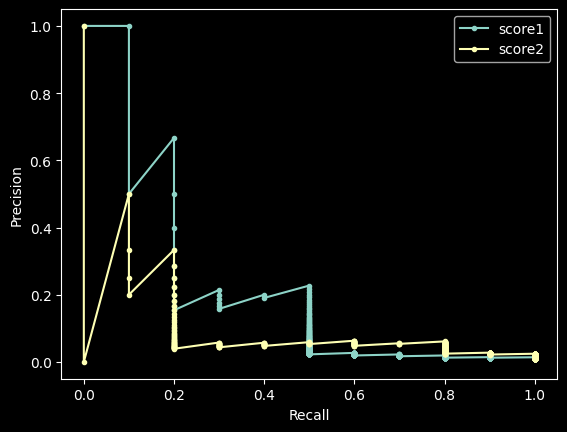

In [112]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

precision1, recall1, _ = precision_recall_curve(t['y_true'], t['y_score1'])
precision2, recall2, _ = precision_recall_curve(t['y_true'], t['y_score2'])


# plot the precision-recall curves
pyplot.plot(recall1, precision1, marker='.', label='score1')
pyplot.plot(recall2, precision2, marker='.', label='score2')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [113]:
from sklearn.metrics import average_precision_score

In [114]:
average_precision_score(t['y_true'],t['y_score1'])

0.2404742335681647

In [115]:
average_precision_score(t['y_true'],t['y_score2'])

0.1238771786028366

# Сравним человеческое и машинное обучение



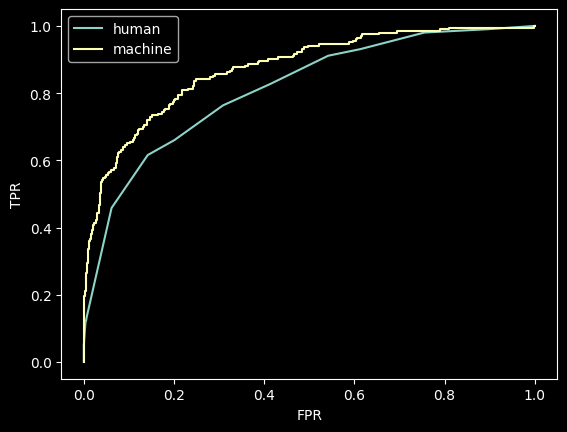

In [116]:
fpr1, tpr1, _ = roc_curve(test['Exited'], test['score_prod_age'])
fpr2, tpr2, _ = roc_curve(test['Exited'], test['score_catboost'])


# plot the precision-recall curves
pyplot.plot(fpr1, tpr1, label='human')
pyplot.plot(fpr2, tpr2, label='machine')
# axis labels
pyplot.xlabel('FPR')
pyplot.ylabel('TPR')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [117]:
roc_auc_score(test['Exited'], test['score_prod_age'])

0.8130860183817394

In [118]:
roc_auc_score(test['Exited'], test['score_catboost'])

0.8736641716782763

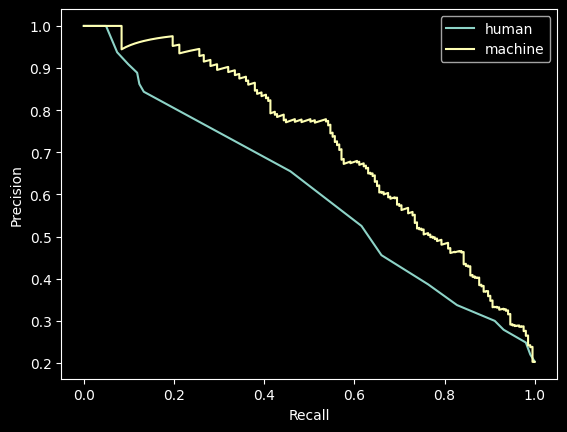

In [119]:
precision1, recall1, _ = precision_recall_curve(test['Exited'], test['score_prod_age'])
precision2, recall2, _ = precision_recall_curve(test['Exited'], test['score_catboost'])


# plot the precision-recall curves
pyplot.plot(recall1, precision1, label='human')
pyplot.plot(recall2, precision2, label='machine')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [120]:
average_precision_score(test['Exited'], test['score_prod_age'])

0.5493470555091149

In [121]:
average_precision_score(test['Exited'], test['score_catboost'])

0.7169823507412415

# Дисбаланс классов не проблема

In [122]:
test['Exited'].mean()

0.203

In [123]:
params = {'verbose':100,
          'eval_metric':'AUC',
          'auto_class_weights':'Balanced',
          'random_seed':42,
          'learning_rate':0.01}

In [124]:
model = CatBoostClassifier(**params)

In [125]:
model.fit(train_data,eval_set=valid_data)

0:	test: 0.8122783	best: 0.8122783 (0)	total: 16.6ms	remaining: 16.6s
100:	test: 0.8584035	best: 0.8586314 (97)	total: 779ms	remaining: 6.93s
200:	test: 0.8635457	best: 0.8636812 (199)	total: 1.47s	remaining: 5.84s
300:	test: 0.8660028	best: 0.8660829 (293)	total: 2.1s	remaining: 4.88s
400:	test: 0.8665324	best: 0.8665324 (400)	total: 2.65s	remaining: 3.96s
500:	test: 0.8671421	best: 0.8671421 (500)	total: 3.19s	remaining: 3.18s
600:	test: 0.8665940	best: 0.8672899 (513)	total: 3.74s	remaining: 2.48s
700:	test: 0.8670066	best: 0.8672899 (513)	total: 4.44s	remaining: 1.9s
800:	test: 0.8665817	best: 0.8673576 (719)	total: 5.2s	remaining: 1.29s
900:	test: 0.8654055	best: 0.8673576 (719)	total: 5.84s	remaining: 642ms
999:	test: 0.8648943	best: 0.8673576 (719)	total: 6.54s	remaining: 0us

bestTest = 0.8673576214
bestIteration = 719

Shrink model to first 720 iterations.


<AxesSubplot: >

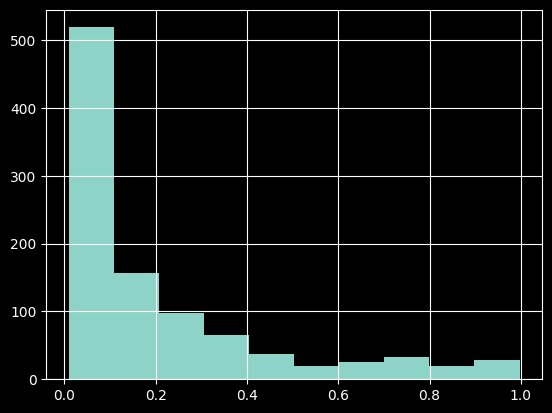

In [126]:
test['score_catboost'].hist()

<AxesSubplot: >

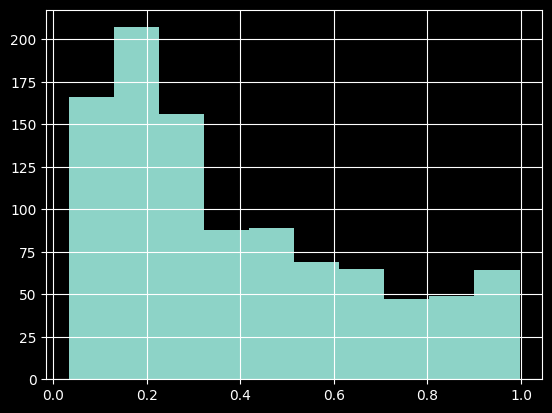

In [127]:
pd.Series(model.predict_proba(test[X])[:,1]).hist()

In [128]:
test['score_cat_non_balanced_bins'] = pd.cut(test['score_catboost'],10)

In [129]:
test.groupby('score_cat_non_balanced_bins')['Exited'].agg(['count','mean'])

,count,mean
score_cat_non_balanced_bins,,
"(0.00858, 0.108]",519,0.044316
"(0.108, 0.207]",156,0.134615
"(0.207, 0.306]",97,0.226804
"(0.306, 0.405]",65,0.338462
"(0.405, 0.503]",38,0.473684
"(0.503, 0.602]",19,0.684211
"(0.602, 0.701]",26,0.538462
"(0.701, 0.8]",33,0.787879
"(0.8, 0.898]",19,0.894737


In [130]:
test['score_catboost_balanced'] = model.predict_proba(test[X])[:,1]

In [131]:
test['score_cat_balanced_bins'] = pd.cut(test['score_catboost_balanced'],10)

In [132]:
test.groupby('score_cat_balanced_bins')['Exited'].agg(['count','mean'])

,count,mean
score_cat_balanced_bins,,
"(0.0324, 0.13]",166,0.012048
"(0.13, 0.226]",207,0.043478
"(0.226, 0.322]",156,0.083333
"(0.322, 0.419]",88,0.102273
"(0.419, 0.515]",89,0.213483
"(0.515, 0.612]",69,0.173913
"(0.612, 0.708]",65,0.400000
"(0.708, 0.804]",47,0.553191
"(0.804, 0.901]",49,0.591837


In [133]:
(4 + 13) / 2

8.5